In [1]:
import numpy as np
import os
import pandas as pd
import json

In [2]:
dim = 512
feat_path = f'./features/orig_repo/{dim}.fea.npy'
knn_graph_path = f'./features/orig_repo/knn.graph.{dim}.bf.npy'
label_path = f'./features/orig_repo/{dim}.labels.npy'
k_at_hop=[200,5]
active_connection=5

In [3]:
features = np.load(feat_path)
knn_graph = np.load(knn_graph_path)[:,:k_at_hop[0]+1]
labels = np.load(label_path)
num_samples = len(features)
depth = len(k_at_hop)
k_at_hop = k_at_hop
active_connection = active_connection

assert np.mean(k_at_hop)>=active_connection

In [4]:
features.shape, labels.shape, knn_graph.shape

((18171, 512), (18171,), (18171, 201))

In [5]:
labels

array([13282, 12252,  2383, ..., 12777,   473, 13641])

In [7]:
knn_graph[0:2]

array([[    0, 12570, 12986, 12628, 12499, 14960, 17737,  1328, 14472,
        17198, 11048, 16618, 13908,  7133,  6486, 10539,  5132,  7582,
        17730,  9211,  2220,  8660, 17023,  7844, 14661,  5871, 17453,
          393,  4231,  7033,  2958,  3876, 18097, 17658, 16891,  2317,
        10214, 15343, 17713,  2217, 16741,  3800, 13367,  9646,  8846,
        17461,  3154,  3507, 11030,  4780, 15951,  8044,  5759,   344,
         4804,  7154,  3184,  3191,  8119,  8686,  2044, 17134, 15067,
        12788,  6306,    75,  3437, 12580, 14093,  1124, 12647, 14396,
         8676,  3623,  7590,  5171,  7511, 17916,  9335, 11591,  2074,
         4359, 16325, 13253, 14183,  6349, 10775,  2895, 11064, 16468,
        14524, 17245,  2825, 12920, 14957,  7691,  8804, 12150,  9997,
        14269,  7635,  7821, 17004, 15531,  1864, 17013, 12304, 16831,
         7814,  8271,   348, 14171,  9762,   911,  4746, 13615,  1353,
        17842,  8265,  5359,  9703,  8465, 14426,  2507, 16252,  8358,
      

In [288]:
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm

def extract_data(path):

    jockey_mask = {}
    sdcl_bbox = {}
    cap_bbox = {}

    wrongs = []

    tree = ET.parse(path)
    root = tree.getroot()

    for i, child in enumerate(tqdm(root)):
        if child.tag != 'image':
            continue

        img_name = child.attrib['name']

        jockey_mask[img_name] = {}
        sdcl_bbox[img_name] = {}
        cap_bbox[img_name] = {}

        for annot in child:
            att = annot.attrib
            if att.get('group_id') is None:
                wrongs.append(img_name)
                continue
            group_id = att['group_id']

            if att['label'] == 'Jockey':
                pts = att['points']
                pts = list(map(lambda x: list(map(lambda k: float(k), x.split(','))), pts.split(';')))
                pts = np.array(pts).reshape((-1,2)).astype(np.int32)
                if jockey_mask[img_name].get(group_id) is not None:
                    jockey_mask[img_name][group_id].append(pts)
                else:
                    jockey_mask[img_name][group_id] = [pts]

            elif att['label'] == 'saddlecloth':
                x1 = round(float(att['xtl']))
                y1 = round(float(att['ytl']))
                x2 = round(float(att['xbr']))
                y2 = round(float(att['ybr']))
                bbox = [x1, y1, x2, y2]
                if sdcl_bbox[img_name].get(group_id) is not None:
                    sdcl_bbox[img_name][group_id].append(bbox)
                else:
                    sdcl_bbox[img_name][group_id] = bbox

            elif att['label'] == 'JockeyCapBox':
                x1 = round(float(att['xtl']))
                y1 = round(float(att['ytl']))
                x2 = round(float(att['xbr']))
                y2 = round(float(att['ybr']))
                bbox = [x1, y1, x2, y2]
                if cap_bbox[img_name].get(group_id) is not None:
                    cap_bbox[img_name][group_id].append(bbox)
                else:
                    cap_bbox[img_name][group_id] = bbox


    for img_name, labels in cap_bbox.items():
        for grp_id, bbox in labels.items():
            if len(bbox) > 4:
                wrongs.append(img_name)

    for img_name, labels in sdcl_bbox.items():
        for grp_id, bbox in labels.items():
            if len(bbox) > 4:
                wrongs.append(img_name)

    for name in wrongs:
        jockey_mask.pop(name, None)
        sdcl_bbox.pop(name, None)
        cap_bbox.pop(name, None)
            
    return jockey_mask, sdcl_bbox, cap_bbox

In [313]:
task = 190
jockey_mask, sdcl_bbox, cap_bbox = extract_data(f'/home/jayson/gcn_clustering/data/annotations_{task}.xml')

  0%|          | 0/1670 [00:00<?, ?it/s]

In [314]:
data = {}

for img_name, bbox_dict in tqdm(cap_bbox.items(), desc='cap: '):
    if data.get(img_name) is None:
        data[img_name] = {}
    save_folder = img_name.replace('/', '_').replace('.jpg', '')
    save_dir = f'/home/jayson/gcn_clustering/data/extracted/{save_folder}/cap'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    img = cv2.imread(os.path.join(f'/home/jayson/gcn_clustering/data/{task}', img_name))
    for grp_id, bbox in bbox_dict.items():
        x1, y1, x2, y2 = bbox
        if data[img_name].get(grp_id) is None:
            data[img_name][grp_id] = {}
        data[img_name][grp_id]['cap'] = list(map(str, [x1, y1, x2, y2]))
        cap_img = img[y1:y2, x1:x2, :]
#         plt.imshow(cap_img)
#         plt.show()
        cv2.imwrite(os.path.join(save_dir, f'{grp_id}.jpg'), cap_img)
        
for img_name, bbox_dict in tqdm(sdcl_bbox.items(), desc='saddlecloth: '):
    if data.get(img_name) is None:
        data[img_name] = {}
    save_folder = img_name.replace('/', '_').replace('.jpg', '')
    save_dir = f'/home/jayson/gcn_clustering/data/extracted/{save_folder}/sdcl'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    img = cv2.imread(os.path.join(f'/home/jayson/gcn_clustering/data/{task}', img_name))
    for grp_id, bbox in bbox_dict.items():
        x1, y1, x2, y2 = bbox
        if data[img_name].get(grp_id) is None:
            data[img_name][grp_id] = {}
        data[img_name][grp_id]['sdcl'] = list(map(str, [x1, y1, x2, y2]))
        sdcl_img = img[y1:y2, x1:x2, :]
#         plt.imshow(sdcl_img)
#         plt.show()
        cv2.imwrite(os.path.join(save_dir, f'{grp_id}.jpg'), sdcl_img)
        
for img_name, mask_dict in tqdm(jockey_mask.items(), desc='jockey'):
    if data.get(img_name) is None:
        data[img_name] = {}
    save_folder = img_name.replace('/', '_').replace('.jpg', '')
    save_dir = f'/home/jayson/gcn_clustering/data/extracted/{save_folder}/jockey'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    img = cv2.imread(os.path.join(f'/home/jayson/gcn_clustering/data/{task}', img_name))
    bboxes = []
    for grp_id, masks in mask_dict.items():
        mask = cv2.fillPoly(np.zeros_like(img), masks, (255, 255, 255))
        bboxes = np.zeros((4, len(masks)))
        for i, mask_pts in enumerate(masks):
            x1 = np.min(mask_pts[:, 0])
            x2 = np.max(mask_pts[:, 0])
            y1 = np.min(mask_pts[:, 1])
            y2 = np.max(mask_pts[:, 1])
            bboxes[:, i] = np.array([x1, y1, x2, y2])
        bboxes = bboxes.astype('int')
        x1 = min(bboxes[0, :])
        y1 = min(bboxes[1, :])
        x2 = max(bboxes[2, :])
        y2 = max(bboxes[3, :])
        if data[img_name].get(grp_id) is None:
            data[img_name][grp_id] = {}
        data[img_name][grp_id]['jockey'] = list(map(str, [x1, y1, x2, y2]))
        jk_img = (img*(mask!=0))[y1:y2, x1:x2, :]
#         plt.imshow(jk_img)
#         plt.show()
        cv2.imwrite(os.path.join(save_dir, f'{grp_id}.jpg'), jk_img)

cap:   0%|          | 0/1658 [00:00<?, ?it/s]

saddlecloth:   0%|          | 0/1658 [00:00<?, ?it/s]

jockey:   0%|          | 0/1658 [00:00<?, ?it/s]

In [315]:
with open(f"/home/jayson/gcn_clustering/data/extracted_{task}.json", "w") as f: 
    json.dump(data, f)

In [279]:
data

{'0027/img000058.jpg': {},
 '0027/img000083.jpg': {'6': {'cap': [1173, 475, 1198, 494],
   'sdcl': [1214, 560, 1254, 605],
   'jockey': [1165, 474, 1244, 590]},
  '3': {'cap': [1308, 464, 1331, 482], 'jockey': [1282, 463, 1343, 549]},
  '8': {'cap': [503, 470, 528, 488], 'jockey': [490, 469, 554, 588]},
  '11': {'cap': [1379, 456, 1404, 475],
   'sdcl': [1398, 555, 1445, 597],
   'jockey': [1372, 453, 1428, 576]},
  '9': {'cap': [1000, 476, 1023, 495], 'jockey': [991, 474, 1048, 582]},
  '5': {'cap': [887, 472, 910, 491],
   'sdcl': [900, 559, 946, 608],
   'jockey': [873, 470, 936, 591]},
  '12': {'cap': [1483, 456, 1508, 476],
   'sdcl': [1506, 544, 1539, 597],
   'jockey': [1477, 454, 1529, 568]},
  '4': {'cap': [578, 486, 602, 505],
   'sdcl': [600, 574, 644, 628],
   'jockey': [565, 486, 628, 588]},
  '10': {'cap': [780, 490, 803, 508], 'jockey': [763, 487, 842, 583]},
  '7': {'cap': [1092, 470, 1116, 488],
   'sdcl': [1109, 558, 1153, 614],
   'jockey': [1083, 468, 1137, 581]},
 

In [327]:
with open(f"/home/jayson/gcn_clustering/data/extracted_129.json", "r") as f: 
    data_129 = json.load(f)
    
with open(f"/home/jayson/gcn_clustering/data/extracted_140.json", "r") as f: 
    data_140 = json.load(f)
    
with open(f"/home/jayson/gcn_clustering/data/extracted_142.json", "r") as f: 
    data_142 = json.load(f)
    
with open(f"/home/jayson/gcn_clustering/data/extracted_189.json", "r") as f: 
    data_189 = json.load(f)
    
with open(f"/home/jayson/gcn_clustering/data/extracted_190.json", "r") as f: 
    data_190 = json.load(f)

In [328]:
len(data_129), len(data_140), len(data_142), len(data_189), len(data_190)

(1546, 1011, 4544, 1613, 1658)

In [329]:
data_129.update(data_140)
data_129.update(data_142)
data_129.update(data_189)
data_129.update(data_190)

In [339]:
len(data_129)

10021

In [340]:
for k, v in data_129.items():
    if len(v) < 1:
        print(k, v)

In [342]:
with open(f"/home/jayson/gcn_clustering/data/extracted_data.json", "w") as f: 
    json.dump(data_129, f)

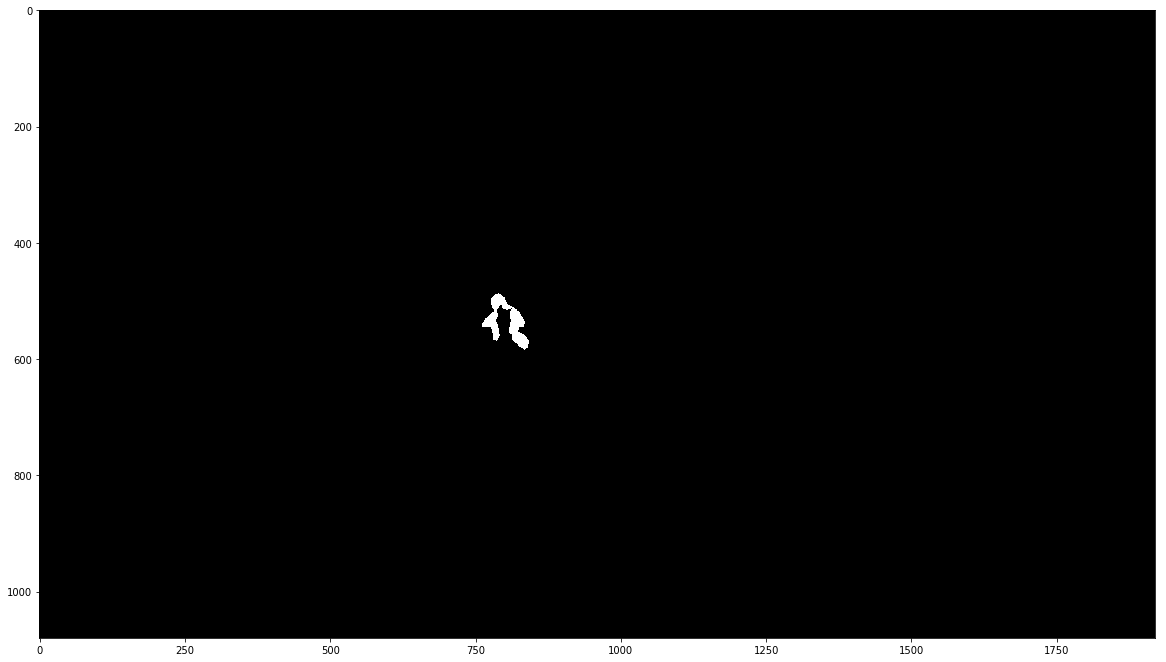

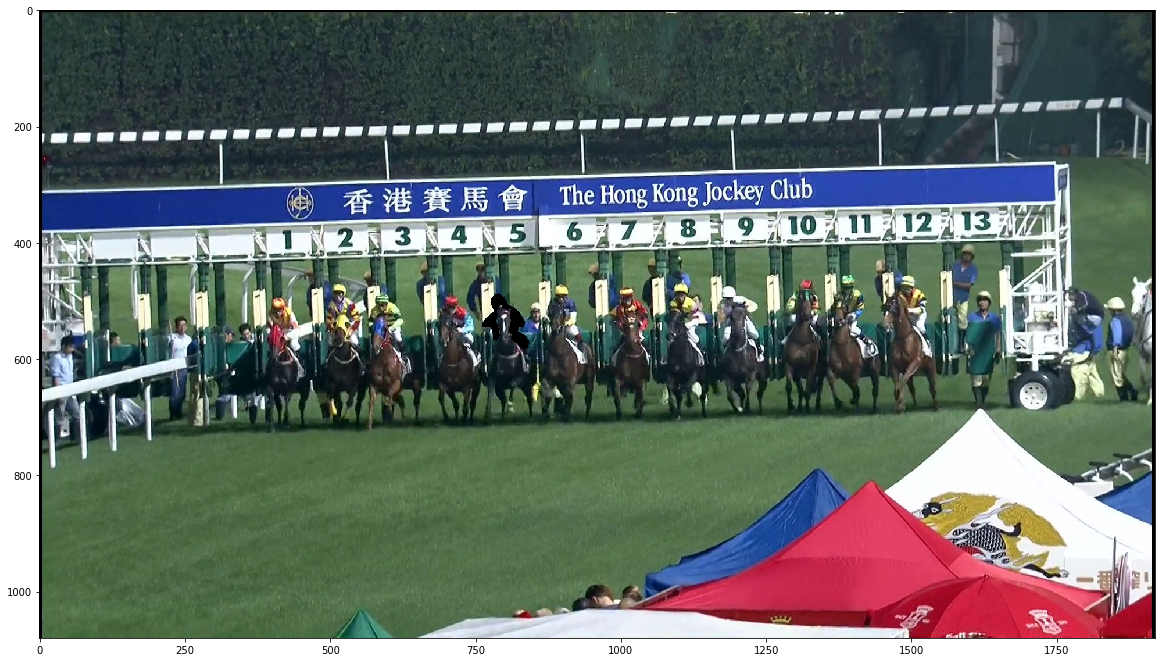

In [148]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

img = cv2.imread('./data/JockeySegmentation_HVT/0027/img000083.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img[:, :, :] = 0
pts = "787.44,568.40;781.39,566.39;781.39,558.32;778.36,545.72;763.74,544.21;763.74,538.66;768.28,530.09;773.32,527.57;777.35,522.03;783.40,517.49;779.87,508.42;777.35,503.38;778.36,495.81;784.91,489.77;791.97,487.75;799.03,493.80;805.58,504.89;807.09,508.42;815.66,510.94;827.26,521.02;835.32,535.64;834.82,544.21;826.25,544.71;823.23,552.78;836.84,560.34;842.89,568.91;841.37,579.49;835.83,583.53;827.76,579.49;822.22,573.45;814.15,567.40;814.15,559.33;808.10,554.29;809.62,548.74;812.64,534.63;810.12,522.53;813.65,512.45;805.08,515.47;799.53,514.97;794.49,505.39;787.94,515.47;788.44,526.06;786.43,534.63;789.45,544.71;791.97,552.78;792.48,560.84"
pts = list(map(lambda x: list(map(lambda k: float(k), x.split(','))), pts.split(';')))
pts = np.array(pts).reshape((-1,1,2)).astype(np.int32)

x1 = np.min(pts[:, 0, 0])
x2 = np.max(pts[:, 0, 0])
y1 = np.min(pts[:, 0, 1])
y2 = np.max(pts[:, 0, 1])

mask = cv2.fillPoly(np.zeros_like(img), [pts], (255, 255, 255))

# cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(20,20))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(20,20))
plt.imshow(img*(mask==0))
plt.show()

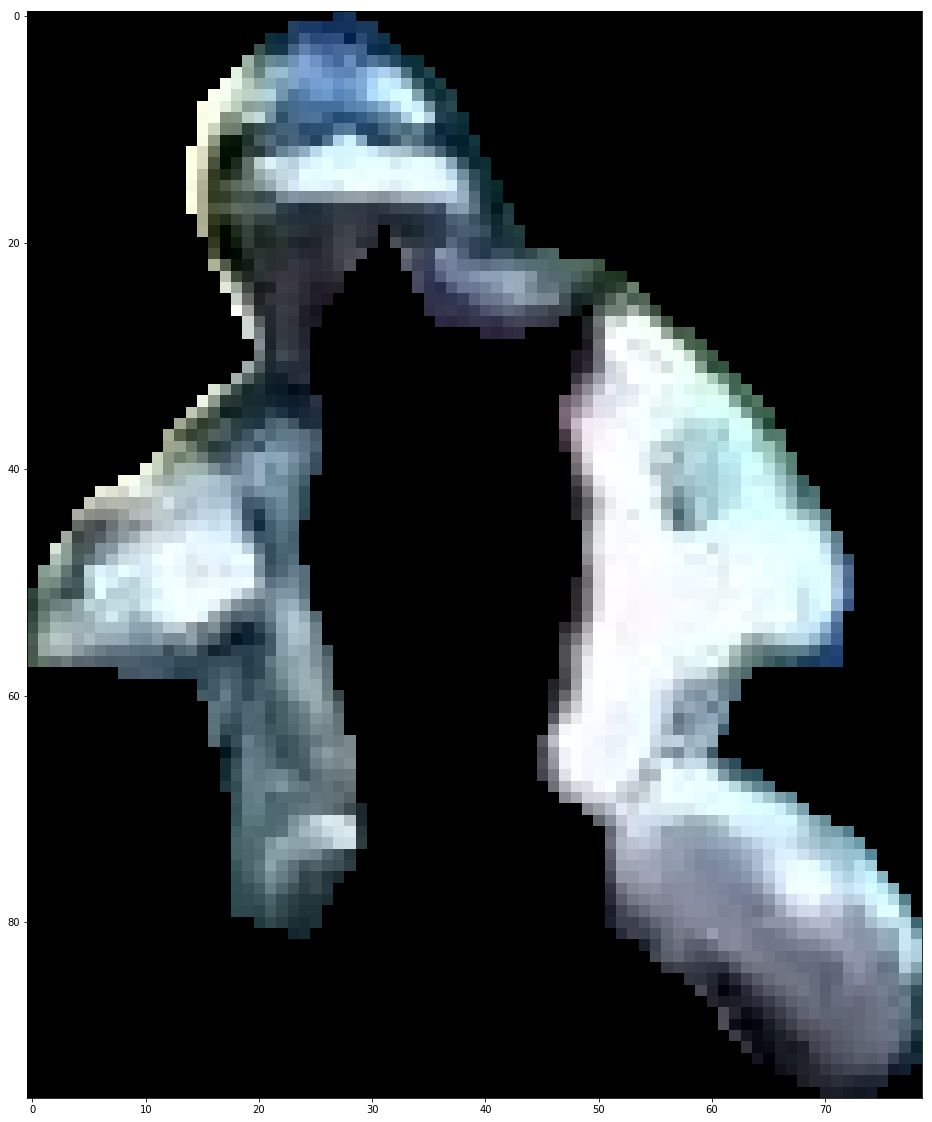

In [149]:
plt.figure(figsize=(20,20))
plt.imshow((img*(mask!=0))[y1:y2, x1:x2, :])
plt.show()

In [134]:
x1 = np.min(pts[:, 0, 0])
x2 = np.max(pts[:, 0, 0])
y1 = np.min(pts[:, 0, 1])
y2 = np.max(pts[:, 0, 1])

In [89]:
coordinates = []
coordinate1 = [[[40, 135], [168,132], [164,330], [2,328]]]
coordinate2 = [[[300, 300], [600,300], [600,600], [300,600]]]
coordinate1 = np.array(coordinate1)
coordinate2 = np.array(coordinate2)
coordinates.append(coordinate1)
coordinates.append(coordinate2)

In [91]:
coordinates

[array([[[ 40, 135],
         [168, 132],
         [164, 330],
         [  2, 328]]]), array([[[300, 300],
         [600, 300],
         [600, 600],
         [300, 600]]])]